In [1]:
import torch
import numpy as np
from models.training import easyTrainer, weights_to_dataset
from models.nODE import nODE, make_nODE_from_parameters
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset

In [2]:
adj_list = []
adj_list.append(np.array([[0.,0.],[0.,0.]]))
adj_list.append(np.array([[0,1.],[0,0]]))
adj_list.append(np.array([[0,-1.],[0,0]]))
adj_list.append(np.array([[0,1.],[1.,0]]))
adj_list.append(np.array([[0,1.],[-1.,0]]))
adj_list.append(np.array([[0,-1.],[-1.,0]]))

In [3]:
class NetworkDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        return self.x[idx], self.y[idx]

In [ ]:
def generate_data(adj,y,ndata=8):
    ODE_dim = 2
    Gamma = np.array([-1., -1.])
    integration_time = 1
    Win = adj
    Wout = np.array([[2., 0], [0, 2.]])
    bin = np.array([[2.], [2.]])
    bout = np.array([[2.], [2.]])

    train_data, test_data = weights_to_dataset(integration_time, Gamma, Win=Win, bin=bin, Wout=Wout, bout=bout, batch_size = ndata)
    print(train_data)
    x = torch.tensor(len(train_data))
    for i, (x0, xt) in enumerate(train_data):
        
        if i == 0:
            x = torch.tensor([xt[0, 0], xt[0, 1], xt[1, 0], xt[1, 1]], dtype=torch.float)
        else:
            x_cur = torch.tensor([xt[0, 0], xt[0, 1], xt[1, 0], xt[1, 1]], dtype=torch.float)
            x = torch.cat((x,x_cur),1)
    
    #print(x)
    y = torch.tensor(abs(adj).flatten(), dtype=torch.float)[1:3]


    return x,y

x_train = []
y_train = []
for graph_ind in [0,1,2,3,4,5]:
    for i in range(0,100):
        x, y = generate_data(adj_list[graph_ind], graph_ind)
        x_train.append(x)
        y_train.append(y)
TrainData = NetworkDataset(x_train,y_train)
loader = DataLoader(TrainData, batch_size=64, shuffle=True)

x_test = []
y_test = []
for graph_ind in [0,1,2,3,4,5]:
    for i in range(0,20):
        x, y = generate_data(adj_list[graph_ind], graph_ind)
        x_test.append(x)
        y_test.append(y)
TestData = NetworkDataset(x_test,y_test)
test_loader = DataLoader(TestData, batch_size=100, shuffle=True)

AttributeError: 'DataLoader' object has no attribute 'getitem'

In [134]:
for batch in loader:
    print(batch[0])

tensor([[3.1685, 3.7461, 3.1764, 2.9921],
        [3.0107, 3.6251, 4.2075, 3.3816],
        [1.1226, 3.3467, 2.0562, 1.7369],
        [1.1308, 4.1829, 1.4365, 3.6024],
        [3.9971, 2.9489, 2.6394, 2.4973],
        [0.8779, 3.6660, 1.3174, 2.7780],
        [3.2198, 1.1225, 4.1701, 0.3376],
        [2.5374, 1.4809, 1.7266, 2.1951],
        [2.5520, 2.5369, 4.1216, 3.2832],
        [3.8796, 1.0565, 4.0179, 0.7093],
        [0.2575, 3.9775, 1.1627, 3.2567],
        [1.9852, 1.8266, 1.9312, 2.0739],
        [2.4959, 2.9366, 2.5312, 3.3000],
        [4.2108, 3.0742, 2.6568, 3.4720],
        [1.9516, 2.4633, 1.4716, 2.4973],
        [4.0281, 2.9512, 3.2190, 3.5564],
        [3.7499, 2.7972, 4.2924, 4.1479],
        [2.9748, 3.9682, 3.8561, 2.7648],
        [2.8578, 1.1437, 3.9932, 1.6131],
        [1.8559, 2.0518, 3.2335, 0.6213],
        [1.1454, 2.9330, 0.8540, 3.9000],
        [2.5457, 3.7866, 2.5470, 3.8712],
        [3.6751, 1.1575, 3.7685, 0.8182],
        [4.2571, 2.8720, 3.0623, 3

In [135]:
class lin_net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(4, 10)  # Linear layer
        self.linear2 = torch.nn.Linear(10, 10)  # Linear layer
        self.linear3 = torch.nn.Linear(10, 10)  # Linear layer
        self.linear4 = torch.nn.Linear(10, 10)  # Linear layer
        self.linear5 = torch.nn.Linear(10, 2) # Linear layer to output

    def forward(self, data):
        x = data
        x = self.linear(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        # x = self.linear4(x)
        # x = F.relu(x)
        x = self.linear5(x)
        x = torch.sigmoid(50*x)
        # x = F.dropout(x, training=self.training)
        # x = self.conv2(x, edge_index)
        # Here we aggregate the output from all nodes
        


        return x

In [140]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = lin_net().to(device)

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

model.train()
testloss = []
for epoch in range(600):
    loss = 0
    for batch in loader:
        loss = 0
        data = batch[0].to(device)
        #data = data_point.to(device)
        optimizer.zero_grad()
        out = model(data)

        target = batch[1].to(device).float()
        
        loss = loss + loss_fn(out.float(), target)
        loss = loss.float()

        loss.backward()
        optimizer.step()
    
    for batch in test_loader:
        data = batch[0].to(device)
        optimizer.zero_grad()
        out = model(data)

        target = batch[1].to(device).float()
        loss = loss + loss_fn(out.float(), target)
        loss = loss.float()
    testloss.append(loss)
    print('Test loss:')
    print(loss)

Test loss:
tensor(0.4956, device='cuda:0', grad_fn=<AddBackward0>)
Test loss:
tensor(0.4393, device='cuda:0', grad_fn=<AddBackward0>)
Test loss:
tensor(0.4410, device='cuda:0', grad_fn=<AddBackward0>)
Test loss:
tensor(0.4281, device='cuda:0', grad_fn=<AddBackward0>)
Test loss:
tensor(0.4459, device='cuda:0', grad_fn=<AddBackward0>)
Test loss:
tensor(0.4251, device='cuda:0', grad_fn=<AddBackward0>)
Test loss:
tensor(0.3557, device='cuda:0', grad_fn=<AddBackward0>)
Test loss:
tensor(0.4335, device='cuda:0', grad_fn=<AddBackward0>)
Test loss:
tensor(0.4851, device='cuda:0', grad_fn=<AddBackward0>)
Test loss:
tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)
Test loss:
tensor(0.4233, device='cuda:0', grad_fn=<AddBackward0>)
Test loss:
tensor(0.3695, device='cuda:0', grad_fn=<AddBackward0>)
Test loss:
tensor(0.4089, device='cuda:0', grad_fn=<AddBackward0>)
Test loss:
tensor(0.3909, device='cuda:0', grad_fn=<AddBackward0>)
Test loss:
tensor(0.4185, device='cuda:0', grad_fn=<AddBackwar

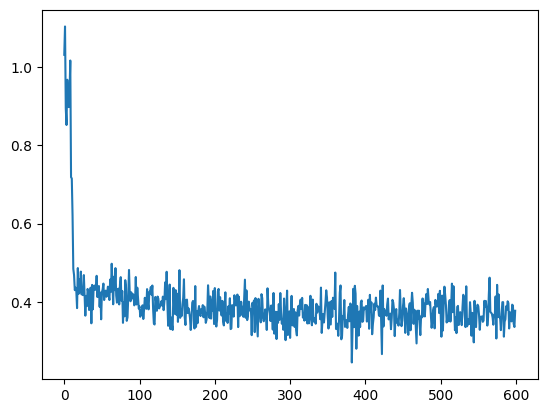

In [137]:
import matplotlib
loss_vec = np.zeros(len(testloss))
for k in range(0,len(testloss)):
    loss_vec[k] = testloss[k].cpu().detach().numpy()

matplotlib.pyplot.plot(range(len(testloss)),loss_vec)

In [142]:
correct = 0
total = 0
for data_point in TestData:
    data = data_point[0].to(device)
    out = model(data)

    guess = out.cpu() > 0.7
    print(guess)
    print(data_point[1])
    if sum(abs(guess.float()-data_point[1])) < 0.001:
        correct += 1
    total += 1

print(correct/total)

tensor([False, False])
tensor([0., 0.])
tensor([ True, False])
tensor([0., 0.])
tensor([ True, False])
tensor([0., 0.])
tensor([ True, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([ True, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([ True, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([ True, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([ True, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([ True, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([ True, False])
tensor([1., 0.])
tensor([ True, False])
tensor([1., 0.])
tensor([False, False])
tensor([1., 0.])
tensor([False, False])
tensor([1., 0.])
tensor([ True, False])
tensor([1., 0.])
